<h1><b>Machine Learning Based Clustering and Segmentation for Navigation<b></h1>

<h3><b>Introduction</b></h3>
    <p>
    The main aspect of this project is to explore neighborhoods within the Greater Toronto Area and find correlations within those communities that our Foursquare API can solve. Given the topics of crime rate, population information,  and income sources and taxes we have found correlations among them that our Foursquare API can dig deeper into.  
    </p>
<h3><b>Project Contribution</b></h3>
    <p>
    The project contribution is to find correlations between topics surrounding the crime rate, population information and income sources. The purpose of this Jupyter notebook is to focus on the following correlation.
    </p>
    The chosen correlations for this project is the correlation between crimes such as homicides and assaults in low income areas (Under $5,000). There is evidence to suggest that there is a correlation amongst these topics. Due to the intensity of specific clusters.
    The clusters that are created from these correlations will allow us to look at the venues in each of these neighbourhoods. Where we can view the type of venues that are common in these clusters.
<h3><b>Prerequisite</b></h3>
<ul>
    <li>Foursquare API</li>

</ul>
<h3><b>Datasets Used</b></h3>
<ul>
    <li>Postal Code Dataset</li>
    <li>Neighbourhood Dataset</li>
    <li>Population Dataset</li>
    <li>Crime Dataset</li>
</ul>

<h3><b>Import Statements</b></h3>

In [1]:
from dotenv import load_dotenv
from dotenv import dotenv_values

import folium
import requests
import os

import pandas as pd 
from pandas import json_normalize

from bs4 import BeautifulSoup as bs
from sklearn.cluster import KMeans

import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

<h3><b>1 - Download Datasets</b></h3>
<p>The following datasets will be the basis of this project. These datasets were written to a csv file using scraping from various resources.</p>


<h4><b>1.1 - Create the Dataframe for Neighborhood Information</b></h4>
<p>Section 1.1 is an culmination of the postal code dataset and neighbourhood dataset that were merged together.</p>

In [2]:
path = os.getcwd()
path = os.path.join(path,"datasets/neighborhood-data.csv")
postcodes = pd.read_csv(path)
postcodes.drop(postcodes.columns[[0]], axis=1, inplace=True)
postcodes.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


<h4><b>1.2 - Create the Dataframe for Homicide Rates and Crime Rates</b></h4>
<p>Section 1.2 creates a Dataframe for the crime rates information from the Toronto police dataset.</p>

In [3]:
path2 = os.getcwd()
path2 = os.path.join(path2,"datasets/neighbourhood-crime-rates.csv")
crimedata = pd.read_csv(path2)
crimedata.drop(crimedata.columns[[0]], axis=1, inplace=True)

<h4><b>1.3 - Combine the Neighbourhood Dataset with the Crime Dataset</b></h4>
<p>Section 1.3 combines both sections 1.1 and section 1.2, to give a large Dataframe that holds the data.</p>

In [4]:
path3 = os.getcwd()
path3 = os.path.join(path3,"datasets/combined-dataset.csv")
combined_data = pd.read_csv(path3)
combined_data.drop(combined_data.columns[[0]], axis=1, inplace=True)
combined_data.head()

,Postcode,Borough,Neighbourhood,Hood_ID,Population,Assault_AVG,Assault_Rate_2019,AutoTheft_AVG,AutoTheft_Rate_2019,Homicide_AVG,Homicide_Rate_2019,Latitude,Longitude
0,M3A,North York,Parkwoods,45,34805,159.7,454.0,31.5,91.9,0.3,2.9,43.751,-79.323
1,M4A,North York,Victoria Village,43,17510,119.3,753.9,16.5,102.8,0.7,5.7,43.735,-79.312
2,M6A,North York,Lawrence Heights,32,22372,104.0,518.5,28.5,102.8,0.2,0.0,43.722,-79.451
3,M1B,Scarborough,Rouge,131,46496,173.3,391.4,50.5,187.1,0.8,0.0,43.804,-79.165
4,M1B,Scarborough,Malvern,132,43794,278.2,760.4,47.2,162.1,1.7,2.3,43.809,-79.221


<h4><b>1.4 - Create the Dataframe for the Population Dataset</b></h4>
<p>Section 1.4 creates a Dataframe for the population dataset that is gathered from the Open Toronto website.</p>

In [5]:
path4 = os.getcwd()
path4 = os.path.join(path4,"datasets/population-dataset-combined.csv")
population_data = pd.read_csv(path4)
population_data.drop(population_data.columns[[0]], axis=1, inplace=True)
population_data.head()

,Postcode,Borough,Neighbourhood,Neighbourhood Number,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data","No certificate, diploma or degree",Secondary (high) school diploma or equivalency certificate,Trades certificate or diploma other than Certificate of Apprenticeship or Certificate of Qualification,Certificate of Apprenticeship or Certificate of Qualification,"College, CEGEP or other non-university certificate or diploma",...,"$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 and over","$200,000 and over",Latitude,Longitude
0,M3A,North York,Parkwoods,45,28890,4140,7660,700,605,5295,...,620,"1,200","1,025",880,790,650,3795,890,43.751,-79.323
1,M6A,North York,Lawrence Manor,32,17080,2675,4340,505,330,2635,...,335,735,565,500,435,315,2155,755,43.726,-79.436
2,M1B,Scarborough,Rouge,131,38125,6580,11740,1020,635,7740,...,455,970,950,930,940,845,6060,1075,43.805,-79.166
3,M1B,Scarborough,Malvern,132,35885,7345,11575,1155,710,6915,...,655,"1,360","1,200","1,000",905,795,3280,225,43.809,-79.222
4,M3B,North York,Don Mills North,42,23390,2295,5150,450,345,3490,...,400,930,885,780,655,605,4615,1750,43.761,-79.411


<h3><b>2 - Foursquare API Initialization and Check</b></h3>
<p>The following section works on gathering data from the Foursquare API, which will later be mapped to a Dataframe that will allow us to analyze clusters.</p>
<h4><b>Category Codes:</b></h4>
<ul>
    <li>10000 - Arts and Entertainment</li>
    <li>11000 - Business and Professional Services</li>
    <li>12000 - Community and Government</li>
    <li>13000 - Dining and Drinking</li>
    <li>14000 - Event</li>
    <li>15000 - Health and Medicine</li>
    <li>16000 - Landmarks and Outdoors</li>
    <li>17000 - Retail</li>
    <li>18000 - Sports and Recreation</li>
    <li>19000 - Travel and Transportation</li>
</ul>

<h4><b>2.1 - Create Request Function to Retrieve Venue Data</b></h4>
<p>Section 2.1 focuses on the creation of the create_request function, which will allow us to gather venue data.</p>

In [6]:
config = dotenv_values(".env")
url = "https://api.foursquare.com/v3/places/nearby"

headers = {"Accept": "application/json",
            "Authorization": config["API_KEY"]}

response = requests.request("GET", url, headers=headers)

def create_request(coords= None, location = None, categories = None, limit = "10"):
    """
        Important:
            - Coords and location cannot be entered together
            - Location and radius cannot be entered together

        The coords will be a list with latitude and longitude.\n 
        Location will be a city and province such as  "Oshawa, ON".\n
        The category is a string from the above codes, with a default of None.\n
        The limit parameter is a maximum of 50, with a default of 10 requests.\n

        Examples:
            - create_request(coords=[-72.848752,43.895962], limit="1")
            - create_request(coords=[-72.848752,43.895962], categories="10000", limit="2")\n
            - create_request(location=["Oshawa","ON"], limit="2")
            - create_request(location=["Oshawa","ON"], categories="10000", limit="20")
    """

    if(coords and categories == None):
        url = "https://api.foursquare.com/v3/places/search?ll=" + str(coords[0]) + "%2C" + str(coords[1]) + "&radius=500"  + "&limit=" + limit
    elif(coords and categories):
        url = "https://api.foursquare.com/v3/places/search?ll=" + str(coords[0]) + "%2C" + str(coords[1]) +"&categories=" + categories + "&radius=500" + "&limit=" + limit
    elif(location and categories == None):
        url = "https://api.foursquare.com/v3/places/search?" + "near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit
    elif(location and categories):
        url = "https://api.foursquare.com/v3/places/search?" + "categories=" + categories + "&near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit
    else:
        return False
    
    response = requests.request("GET", url, headers=headers)
    
    if(response.status_code == 200):
        return response.json()
    else:
        return False

<h4><b>2.11 - Gather Venues Relating to Government Buildings</b></h4>
<p>The following section tests the create_request function with specific category codes, locations and limits.</p>

In [7]:
latitude = 43.6532
longitude = -79.3832
filtered_columns = ['name', 'categories', 'geocodes.main.latitude', 'geocodes.main.longitude']

results = create_request(location=["Toronto","ON"], categories="12000", limit="10")
venues = json_normalize(results['results'], max_level=3)
venues = venues[filtered_columns]
venues.head()

,name,categories,geocodes.main.latitude,geocodes.main.longitude
0,Toronto Public Library - Toronto Reference Lib...,"[{'id': 12080, 'name': 'Library', 'icon': {'pr...",43.671795,-79.386944
1,Trinity-St Paul's United Church,"[{'id': 12101, 'name': 'Church', 'icon': {'pre...",43.666094,-79.405674
2,North York Public Library,"[{'id': 12080, 'name': 'Library', 'icon': {'pr...",43.768473,-79.412959
3,Toronto St Lawrence Comm Ctr,"[{'id': 12000, 'name': 'Community and Governme...",43.649667,-79.365140
4,Eatonville Public Library,"[{'id': 12080, 'name': 'Library', 'icon': {'pr...",43.646159,-79.559471


<h4><b>2.2 - Create Get Venues Function to Sort Venues</b></h4>
<p>The following section is the creation of the get_venues function that will return a Dataframe of the venues with their respective neighbourhoods and coordinates.</p>

In [8]:
def get_venues(names, latitudes, longitudes):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        results = create_request(location=[lat,lng], limit="50")
        venues = results['results']

        if(len(venues) > 0):
            try:
                venues_list.append([(
                name, 
                lat, 
                lng, 
                venue['name'], 
                venue['geocodes']['main']['latitude'], 
                venue['geocodes']['main']['longitude'], venue['categories'][0]['name']) for venue in venues])
            except:
                continue
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
   
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude',  'Venue Category']
    print("Done Getting Venues")
    return(nearby_venues)

<h4><b>2.3 - Retrieve the Venue DataFrame</b></h4>
<p>The Dataframe that is created below will have the venues that are located in specific neighbourhoods from the dataset above. The venues will be gathered in a 500m radius from the coordinates that are parsed by the function.</p>

In [9]:
toronto_venues = get_venues(names=combined_data["Neighbourhood"], latitudes= combined_data["Latitude"], longitudes=combined_data["Longitude"])
toronto_venues.head()

Done Getting Venues


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.735,-79.312,Jatujak Thai Street Style,43.738304,-79.308697,Thai Restaurant
1,Victoria Village,43.735,-79.312,Damas Grill House & Juice Bar,43.741800,-79.309295,Fast Food Restaurant
2,Victoria Village,43.735,-79.312,Georgy Porgys,43.741917,-79.314700,American Restaurant
3,Victoria Village,43.735,-79.312,Tesla Sales & Service Centre,43.740286,-79.322546,Automotive Retail
4,Victoria Village,43.735,-79.312,Baskin-Robbins,43.742101,-79.314495,Ice Cream Parlor


<h3><b>3 - Analyzing Each Neigborhood</b></h3>

<h4><b>3.1 - Grouping Venues together Based on Neighbourhood</b></h4>
<p></p>

In [10]:
# one hot encoding
toronto_onehot_encoding = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_encoding['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot_encoding.columns[-1]] + list(toronto_onehot_encoding.columns[:-1])
toronto_onehot_encoding = toronto_onehot_encoding[fixed_columns]

toronto_onehot_encoding.head()

toronto_grouped = toronto_onehot_encoding.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Amusement Park,Antique Store,Arcade,Art Gallery,...,Urban Park,Used Car Dealership,Vegan and Vegetarian Restaurant,Video Games Store,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.02,0.02,0.0,0.0,0.0,0.0,0.0
1,Agincourt North,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.02,0.00,0.02,0.0,0.0,0.0,0.0,0.0
2,Alderwood,0.0,0.02,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,Bathurst Manor,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.0,0.02,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,Bayview Village,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0


<h4><b>3.2 - Building Graphs to View the Frequency of Venues for Specific Neighbourhoods</b></h4>
<p></p>

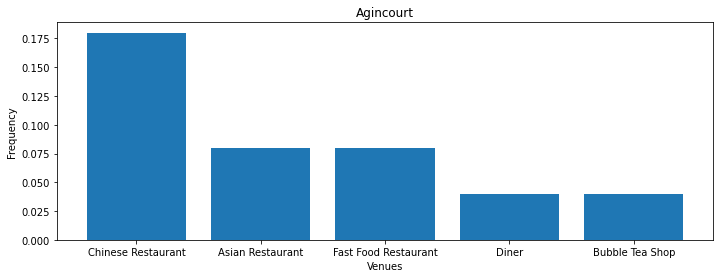

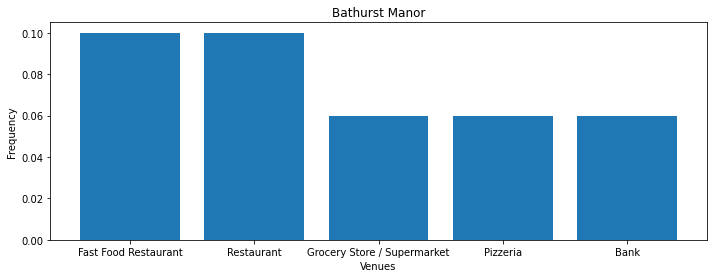

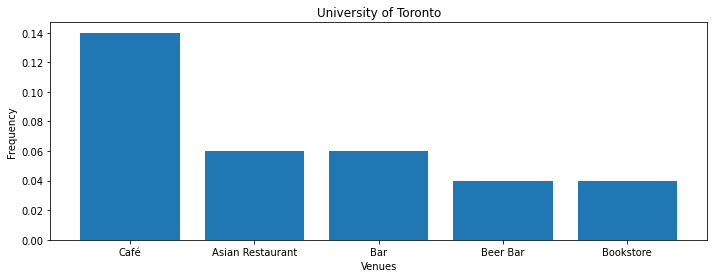

In [11]:
def create_venue_graph(neighbourhood):
    try:
        temp = toronto_grouped[toronto_grouped['Neighbourhood'] == neighbourhood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(5)

        plt.figure(figsize=(40,4))
        plt.subplot(131)
        plt.bar(temp['venue'], temp['freq'])
        plt.title(neighbourhood)
        plt.xlabel("Venues")
        plt.ylabel("Frequency")
        plt.show()
    except:
        print("Try another neighbourhood")

create_venue_graph("Agincourt")
create_venue_graph("Bathurst Manor")
create_venue_graph("University of Toronto")

<h4><b>3.3 - Get Most Common Venues</b></h4>

In [12]:
def common_venues(row):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:10]

indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for i in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for i in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[i, 1:] = common_venues(toronto_grouped.iloc[i, :])

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Diner,Bubble Tea Shop,Cantonese Restaurant,Restaurant,Drugstore,Pizzeria,Bank
1,Agincourt North,Chinese Restaurant,Bakery,Bubble Tea Shop,Bank,Korean Restaurant,Dessert Shop,BBQ Joint,Discount Store,Restaurant,Asian Restaurant
2,Alderwood,Retail,Drugstore,Bookstore,Coffee Shop,Park,American Restaurant,Hiking Trail,"Cafes, Coffee, and Tea Houses",Seafood Restaurant,Burger Joint
3,Bathurst Manor,Fast Food Restaurant,Restaurant,Grocery Store / Supermarket,Pizzeria,Bank,Coffee Shop,Diner,Storage Facility,Deli,Dining and Drinking
4,Bayview Village,Chinese Restaurant,Park,Bank,Fast Food Restaurant,Furniture and Home Store,Grocery Store / Supermarket,Japanese Restaurant,Diner,Drugstore,Hair Salon


<h3><b>4 - Correlation: Educational Buildings and Income </b></h3>


<h4><b>4.1 - Combine Datafames Together and Cluster Together</b></h4>

In [13]:
k = 6
combined_dataframe = pd.merge(combined_data, population_data, on="Neighbourhood")
combined_dataframe
toronto_clustering = combined_dataframe[["Homicide_AVG", "Assault_AVG", "Under $5,000", "Hood_ID", "Neighbourhood Number"]]
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
toronto_clustering
combined_dataframe.insert(0, "Cluster Labels", kmeans.labels_)
combined_dataframe.tail()

,Cluster Labels,Postcode_x,Borough_x,Neighbourhood,Hood_ID,Population,Assault_AVG,Assault_Rate_2019,AutoTheft_AVG,AutoTheft_Rate_2019,...,"$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 and over","$200,000 and over",Latitude_y,Longitude_y
53,2,M8W,Etobicoke,Alderwood,20,12054,36.3,298.7,16.2,116.1,...,165,335,300,320,275,250,1915,360,43.602,-79.545
54,2,M8W,Etobicoke,Long Branch,19,10084,61.7,585.1,12.3,119.0,...,230,400,360,310,295,230,1265,300,43.593,-79.538
55,0,M4X,Downtown Toronto,Cabbagetown,71,11669,102.3,1079.8,10.7,188.5,...,255,425,420,350,295,270,1925,700,43.665,-79.369
56,3,M4X,Downtown Toronto,St. James Town,71,11669,102.3,1079.8,10.7,188.5,...,490,815,600,525,400,340,1170,170,43.671,-79.373
57,1,M8Y,Etobicoke,Mimico NE,17,33964,299.2,959.8,37.3,176.7,...,675,"1,270","1,255","1,120","1,105",920,5455,1245,43.614,-79.495


In [14]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = pd.merge(combined_dataframe, neighbourhoods_venues_sorted, on="Neighbourhood")
toronto_merged.head()

,Cluster Labels,Postcode_x,Borough_x,Neighbourhood,Hood_ID,Population,Assault_AVG,Assault_Rate_2019,AutoTheft_AVG,AutoTheft_Rate_2019,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,M1B,Scarborough,Malvern,132,43794,278.2,760.4,47.2,162.1,...,Fast Food Restaurant,Hair Salon,Bank,Chinese Restaurant,Bakery,Clothing Store,Restaurant,Park,Drugstore,Diner
1,0,M3B,North York,Don Mills North,42,27695,80.5,267.2,21.8,151.7,...,Diner,Restaurant,Bank,Clothing Store,Fast Food Restaurant,Café,Beer Store,Movie Theater,Bicycle Store,Liquor Store
2,0,M6C,York,Humewood-Cedarvale,106,14365,46.3,320.2,16.2,111.4,...,Bank,Fast Food Restaurant,Bakery,BBQ Joint,Bistro,Pizzeria,Café,Ice Cream Parlor,Indian Restaurant,Italian Restaurant
3,2,M9C,Etobicoke,Eringate,11,18588,54.0,236.7,29.7,220.6,...,Bank,Restaurant,Fast Food Restaurant,Park,Deli,Bowling Alley,Drugstore,Beer Store,Bicycle Store,New American Restaurant
4,2,M9C,Etobicoke,Markland Wood,12,10554,20.7,161.1,12.3,85.3,...,Fast Food Restaurant,Bank,Restaurant,Diner,Grocery Store / Supermarket,Sporting Goods Retail,Liquor Store,Drugstore,Coffee Shop,Greek Restaurant


<h4><b>4.2 - Mapping Neighbourhoods Based on Location</b></h4>

In [15]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

for average, lat, lon, neighbourhood, cluster in zip(combined_dataframe["Homicide_AVG"], combined_dataframe['Latitude_y'], combined_dataframe['Longitude_y'], combined_dataframe['Neighbourhood'], combined_dataframe['Cluster Labels']):
    label = folium.Popup("Cluster: " + str(cluster)+ " " + str(neighbourhood) + " Homicide Average: " + str(average), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

<h4><b>4.3 - Mapping Neighbourhoods Based on Clustering</b></h4>

In [16]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for average, lat, lon, neighbourhood, cluster in zip(combined_dataframe["Homicide_AVG"], combined_dataframe['Latitude_y'], combined_dataframe['Longitude_y'], combined_dataframe['Neighbourhood'], combined_dataframe['Cluster Labels']):
    label = folium.Popup("Cluster: " + str(cluster)+ " " + str(neighbourhood) + " Homicide Average: " + str(average), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

<h3><b>5 - Cluster Analysis</b></h3>

<h4><b>5.1 - Display Clusters</b></h4>

In [17]:
# Define display function
def view_cluster(n):
    filtered_columns = ["Cluster Labels", "Neighbourhood" , "Borough_y", "1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue", "6th Most Common Venue", "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", "10th Most Common Venue"]
    cluster_elts = toronto_merged.loc[toronto_merged['Cluster Labels'] == n, toronto_merged.columns[:]]
    toronto_grouped[toronto_grouped['Neighbourhood'] == neighbourhood].T.reset_index()
    cluster_elts = cluster_elts[filtered_columns]
    cluster_elts.reset_index(drop=True, inplace=True)
    print ('Cluster {} has {} Neighbourhood(s)\n'.format(n, cluster_elts.shape[0]))
    return cluster_elts

<h5><b>Cluster 0</b></h5>

In [18]:
view_cluster(0)

Cluster 0 has 17 Neighbourhood(s)



,Cluster Labels,Neighbourhood,Borough_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Don Mills North,North York,Diner,Restaurant,Bank,Clothing Store,Fast Food Restaurant,Café,Beer Store,Movie Theater,Bicycle Store,Liquor Store
1,0,Humewood-Cedarvale,York,Bank,Fast Food Restaurant,Bakery,BBQ Joint,Bistro,Pizzeria,Café,Ice Cream Parlor,Indian Restaurant,Italian Restaurant
2,0,The Beaches,East Toronto,Bakery,Pub,Beach,Restaurant,Park,Coffee Shop,Caterer,Bistro,Asian Restaurant,Dog Park
3,0,Hillcrest Village,North York,Chinese Restaurant,Bakery,Fast Food Restaurant,Cantonese Restaurant,Bank,Restaurant,BBQ Joint,Diner,Sushi Restaurant,Grocery Store / Supermarket
4,0,Thorncliffe Park,East York,Fast Food Restaurant,Bank,Car Dealership,Bicycle Store,Sporting Goods Retail,Burger Joint,Bakery,Department Store,Grocery Store / Supermarket,Liquor Store
5,0,Trinity,West Toronto,Café,Bakery,Bar,Hair Salon,Coffee Shop,Beer Bar,Korean Restaurant,Restaurant,Japanese Restaurant,Vietnamese Restaurant
6,0,Ionview,Scarborough,Fast Food Restaurant,Restaurant,Bank,Discount Store,Grocery Store / Supermarket,Burger Joint,Car Dealership,Asian Restaurant,Department Store,Coffee Shop
7,0,Riverdale,East Toronto,Bakery,Greek Restaurant,Pizzeria,Pub,Italian Restaurant,Burger Joint,Café,Diner,Brewery,Ice Cream Parlor
8,0,Mount Dennis,York,Fast Food Restaurant,Restaurant,Bakery,BBQ Joint,Grocery Store / Supermarket,Storage Facility,Brewery,Department Store,Asian Restaurant,Café
9,0,The Junction North,York,Fast Food Restaurant,Restaurant,Café,Brewery,Bar,Bank,Burger Joint,Asian Restaurant,Shopping Mall,Sports Bar


<h5><b>Cluster 1</b></h5>

In [19]:
view_cluster(1)

Cluster 1 has 5 Neighbourhood(s)



,Cluster Labels,Neighbourhood,Borough_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Woburn,Scarborough,Restaurant,Bank,Coffee Shop,Diner,Hair Salon,Indian Restaurant,Fried Chicken Joint,Chinese Restaurant,Bar,Drugstore
1,1,York University,North York,Restaurant,Drugstore,Fast Food Restaurant,Caribbean Restaurant,Bank,Sushi Restaurant,Discount Store,Café,Bistro,Pizzeria
2,1,Chinatown,Downtown Toronto,Café,Coffee Shop,Bar,Music Venue,Restaurant,Diner,Park,Ramen Restaurant,Pizzeria,Furniture and Home Store
3,1,South Niagara,Downtown Toronto,Bar,Park,Restaurant,Café,Coffee Shop,Scenic Lookout,Ramen Restaurant,Music Venue,Sushi Restaurant,Cocktail Bar
4,1,Mimico NE,Etobicoke,Pizzeria,Bank,Restaurant,Coffee Shop,Thai Restaurant,Italian Restaurant,Diner,Grocery Store / Supermarket,Ice Cream Parlor,Fast Food Restaurant


<h5><b>Cluster 2</b></h5>

In [20]:
view_cluster(2)

Cluster 2 has 18 Neighbourhood(s)



,Cluster Labels,Neighbourhood,Borough_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Eringate,Etobicoke,Bank,Restaurant,Fast Food Restaurant,Park,Deli,Bowling Alley,Drugstore,Beer Store,Bicycle Store,New American Restaurant
1,2,Markland Wood,Etobicoke,Fast Food Restaurant,Bank,Restaurant,Diner,Grocery Store / Supermarket,Sporting Goods Retail,Liquor Store,Drugstore,Coffee Shop,Greek Restaurant
2,2,Guildwood,Scarborough,Fast Food Restaurant,Restaurant,Convenience Store,Park,Bank,Hair Salon,Nursing Home,Sports Bar,Retirement Home,Chinese Restaurant
3,2,Caledonia-Fairbanks,York,Bakery,Bank,Italian Restaurant,BBQ Joint,Furniture and Home Store,Grocery Store / Supermarket,Diner,Drugstore,Burger Joint,Fast Food Restaurant
4,2,Leaside,East York,Bakery,Indian Restaurant,Sushi Restaurant,Grocery Store / Supermarket,Thai Restaurant,Bar,Fast Food Restaurant,Asian Restaurant,Butcher,Liquor Store
5,2,Bathurst Manor,North York,Fast Food Restaurant,Restaurant,Grocery Store / Supermarket,Pizzeria,Bank,Coffee Shop,Diner,Storage Facility,Deli,Dining and Drinking
6,2,Fairview,North York,Middle Eastern Restaurant,Drugstore,Restaurant,Clothing Store,Fish and Chips Shop,Burger Joint,Bakery,Coffee Shop,Hair Salon,Car Wash and Detail
7,2,Bedford Park,North York,Sushi Restaurant,Italian Restaurant,Bakery,Fast Food Restaurant,Pub,Drugstore,Restaurant,Café,Home Improvement Service,Bridal Store
8,2,Keelesdale,York,Fast Food Restaurant,Bakery,Grocery Store / Supermarket,Restaurant,Department Store,Brewery,Café,Burger Joint,Liquor Store,Coffee Shop
9,2,Humberlea,North York,Park,Fast Food Restaurant,Bank,Restaurant,Grocery Store / Supermarket,Clothing Store,Vietnamese Restaurant,Convenience Store,Beer Store,Bridge


<h5><b>Cluster 3</b></h5>

In [21]:
view_cluster(3)

Cluster 3 has 4 Neighbourhood(s)



,Cluster Labels,Neighbourhood,Borough_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Henry Farm,North York,Furniture and Home Store,Park,Thai Restaurant,Coffee Shop,Café,Grocery Store / Supermarket,Seafood Restaurant,Restaurant,Fast Food Restaurant,Diner
1,3,Bayview Village,North York,Chinese Restaurant,Park,Bank,Fast Food Restaurant,Furniture and Home Store,Grocery Store / Supermarket,Japanese Restaurant,Diner,Drugstore,Hair Salon
2,3,L'Amoreaux West,Scarborough,Fast Food Restaurant,Diner,Bank,Restaurant,Chinese Restaurant,Drugstore,Falafel Restaurant,Middle Eastern Restaurant,Bakery,Beer Store
3,3,St. James Town,Downtown Toronto,Café,Fast Food Restaurant,Bar,Park,Diner,Grocery Store / Supermarket,Japanese Restaurant,Bookstore,Pizzeria,Ramen Restaurant


<h5><b>Cluster 4</b></h5>

In [22]:
view_cluster(4)

Cluster 4 has 8 Neighbourhood(s)



,Cluster Labels,Neighbourhood,Borough_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Malvern,Scarborough,Fast Food Restaurant,Hair Salon,Bank,Chinese Restaurant,Bakery,Clothing Store,Restaurant,Park,Drugstore,Diner
1,4,Morningside,Scarborough,Fast Food Restaurant,Coffee Shop,Restaurant,Drugstore,Park,Pizzeria,Movie Theater,College and University,Tennis,Recreation Center
2,4,West Hill,Scarborough,Restaurant,Fast Food Restaurant,Bank,Pizzeria,Convenience Store,Grocery Store / Supermarket,Coffee Shop,Discount Store,Chinese Restaurant,Juice Bar
3,4,Dovercourt Village,West Toronto,Café,Bakery,Coffee Shop,Bar,Brewery,Italian Restaurant,Grocery Store / Supermarket,BBQ Joint,Gift Store,Comedy Club
4,4,Scarborough Village,Scarborough,Bank,Restaurant,Diner,Fast Food Restaurant,Coffee Shop,Drugstore,Fried Chicken Joint,Pizzeria,Bar,Indian Restaurant
5,4,Oakridge,Scarborough,Grocery Store / Supermarket,Bank,Fast Food Restaurant,Restaurant,Retail,Liquor Store,Ice Cream Parlor,Discount Store,Golf Course,Event Service
6,4,Wexford,Scarborough,Diner,Fast Food Restaurant,Bakery,Grocery Store / Supermarket,Restaurant,Bank,Burger Joint,Discount Store,Seafood Restaurant,Middle Eastern Restaurant
7,4,Jamestown,Etobicoke,Café,Park,Diner,Bar,Grocery Store / Supermarket,Thai Restaurant,Ramen Restaurant,Pizzeria,Bakery,Gay Bar


<h5><b>Cluster 5</b></h5>

In [23]:
view_cluster(5)

Cluster 5 has 1 Neighbourhood(s)



,Cluster Labels,Neighbourhood,Borough_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,The Annex,Central Toronto,Café,Grocery Store / Supermarket,Korean Restaurant,Vegan and Vegetarian Restaurant,Coffee Shop,Beer Bar,Bar,Japanese Restaurant,BBQ Joint,Park


<h4><b>5.2 - Investigating Clusters</b</4>

<h4><b>5.21 - Investigating the Correlations in the Cluster</b></h3>

In [24]:
def investigate_cluster_correlations(cluster):
    filtered_columns = ["Neighbourhood", "Borough_y", "Homicide_AVG", "Assault_AVG", "Under $5,000"]
    temp = toronto_merged[toronto_merged['Cluster Labels'] == cluster].reset_index()
    temp = temp[filtered_columns[2:]].mean()
    print("Cluster Number: " + str(cluster))
    print(temp)
    print("---------------")

In [25]:
investigate_cluster_correlations(0)
investigate_cluster_correlations(1)
investigate_cluster_correlations(2)
investigate_cluster_correlations(3)
investigate_cluster_correlations(4)
investigate_cluster_correlations(5)


Cluster Number: 0
Homicide_AVG      0.376471
Assault_AVG      95.552941
Under $5,000    183.823529
dtype: float64
---------------
Cluster Number: 1
Homicide_AVG      1.0
Assault_AVG     329.8
Under $5,000    476.0
dtype: float64
---------------
Cluster Number: 2
Homicide_AVG     0.294444
Assault_AVG     55.238889
Under $5,000    85.555556
dtype: float64
---------------
Cluster Number: 3
Homicide_AVG      0.375
Assault_AVG     104.050
Under $5,000    462.500
dtype: float64
---------------
Cluster Number: 4
Homicide_AVG      1.1750
Assault_AVG     232.2625
Under $5,000    169.3750
dtype: float64
---------------
Cluster Number: 5
Homicide_AVG      0.5
Assault_AVG     246.3
Under $5,000    850.0
dtype: float64
---------------


<h4><b>5.22 - Investigating the Correlations in the Cluster</b></h3>

In [26]:
def investigate_cluster_venues(cluster):
    venue_column = ["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue", "6th Most Common Venue", "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", "10th Most Common Venue"]
    temp = toronto_merged[toronto_merged['Cluster Labels'] == cluster].reset_index()
    temp = temp[venue_column]
    temp = temp.stack().value_counts()
    temp = pd.DataFrame(temp).reset_index()
    temp = temp.iloc[:5]
    temp.columns = ["Venue", "Count"]
    plt.figure(figsize=(40,4))
    plt.subplot(131)
    plt.bar(temp["Venue"], temp["Count"])
    plt.title("Cluster Number: " + str(cluster))
    plt.xlabel("Venue Type")
    plt.ylabel("Number of Venues")
    plt.show()
    return temp

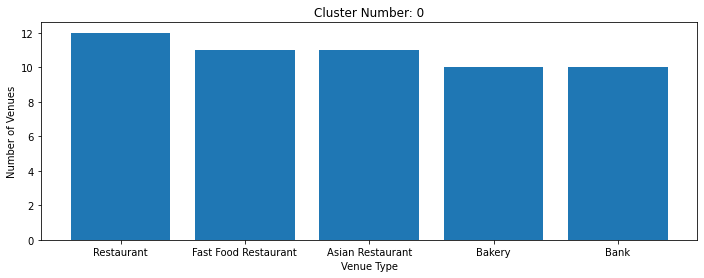

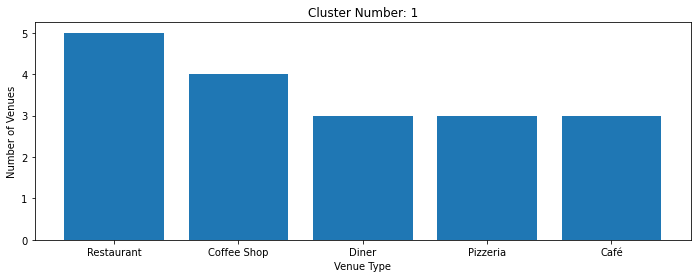

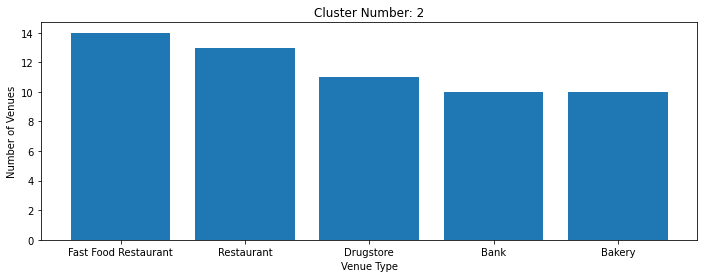

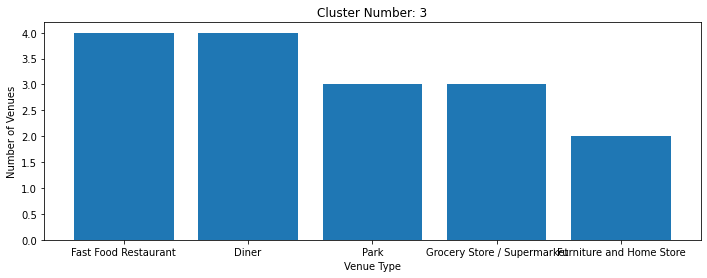

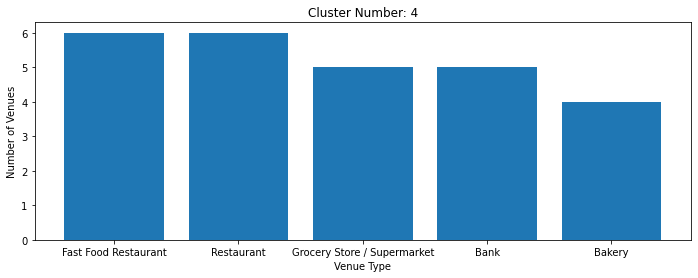

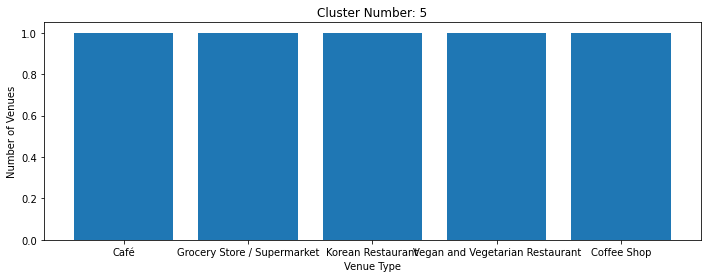

,Venue,Count
0,Café,1
1,Grocery Store / Supermarket,1
2,Korean Restaurant,1
3,Vegan and Vegetarian Restaurant,1
4,Coffee Shop,1


In [27]:
investigate_cluster_venues(0)
investigate_cluster_venues(1)
investigate_cluster_venues(2)
investigate_cluster_venues(3)
investigate_cluster_venues(4)
investigate_cluster_venues(5)

<h3><b>6 - Conclusion</b></h3>
<p>The objective of this project is to cluster together a minimum of two correlations. These clusters will allow us to identify common venues among these correlations. Finding common venues among these clusters will allow us to better understand these specific neighbourhoods. For instance, looking at section 3.2 looking at an area like Agincourt there is large number of food services. But lets say you decide to cluster together based on specific factors, you can derive the occurences of such locations based on these factors. 

<h4><b>6.1 - Analysis of Clustering</b></h4>
<figure>
    <img src="images/agincourt-venues.png">
    <figcaption><i>Frequency of Venues in Agincourt from Section 3.2 with High Restaurant Frequency</i></figcaption>
</figure>

First we are to derive neighbourhoods based on location, this will allow us to create the basis of our map without any clustering or data being used to decide the color of the points.
<figure>
    <img src="images/mapping.png">
    <figcaption><i>The Mapping of Neighbourhoods based solely on location from Section 4.2</i></figcaption>
</figure>

The chosen correlations for this project is the correlation between crimes such as homicides and assaults in low income areas (under $5,000). There is evidence to suggest that there is a correlation amongst these topics. Due to the intensity of specific clusters.

<figure>
    <img src="images/mapping-clustering.png">
    <figcaption><i>The Mapping of Neighbourhoods with Clustering based on the choosen correlation from Section 4.3</i></figcaption>
</figure>

Based on the image above it is clear that there is a correlation between these ideas. Where higher homicide rates and assault rates are more prevalent in low income areas (under $5,000). The purple cluster (cluster 1) are the only cluster that don't have a form of concentration but the other clusters are far more concentrated. Specifically, the green cluster (cluster 4) has the most concentration. Therefore, we will be taking a closer look at these 2 clusters.

<b>Cluster 1:</b>
From section 5, we are able to analyze these clusters. Where we can look into the averages of the correlations of the cluster 1.
<figure>
    <img src="images/cluster-1-averages.png">
    <figcaption><i>The Mapping of Neighbourhoods with Clustering based on the choosen correlation from Section 4.3</i></figcaption>
</figure>
This image above outlines the averages of the chosen correlations for cluster 1. From this we can demise that cluster 1 in terms of crime is on the higher end of the other clusters, along with being the 2nd worst in terms of income under $5,000. This shows a direct correlation between crime rates and lower income.
<figure>
    <img src="images/cluster-1-venues.png">
    <figcaption><i>The Mapping of Neighbourhoods with Clustering based on the choosen correlation from Section 4.3</i></figcaption>
</figure>
This image above outlines the averages of the chosen correlations for cluster 1. From this we can demise that cluster 1 in terms of crime is on the higher end of the other clusters, along with being the 2nd worst in terms of income under $5,000. This shows a direct correlation between crime rates and lower income.

<b>Cluster 4:</b>
From section 5, we are able to analyze these clusters. Where we can look into the averages of the correlations of the cluster 4.
<figure>
    <img src="images/cluster-4-averages.png">
    <figcaption><i>The Mapping of Neighbourhoods with Clustering based on the choosen correlation from Section 4.3</i></figcaption>
</figure>
This image above outlines the averages of the chosen correlations for cluster 4. The figure above demonstrates that cluster 4 has the highest average of homicides and the second highest number of assaults. Showcasing a correlation between these crimes in this area, it is important to consider that this area is not as densely populated as other areas.
<figure>
    <img src="images/cluster-4-venues.png">
    <figcaption><i>The Mapping of Neighbourhoods with Clustering based on the choosen correlation from Section 4.3</i></figcaption>
</figure>
This image above outlines the averages of the chosen correlations for cluster 4. The figure above demonstrates that cluster 4 showcases that the most common venue in this cluster are fast food restaurants which differs from cluster 1. But it is more in line with other clusters that have tighter correlations. After analyzing these clusters, there seems to be a correlation between restaurants and crime, where areas with higher crime tends to happen in areas with restaurants.
</p>

<h4><b>6.2 - Final Correlations</b></h4>
<p>
Within section 6.1, the results are summarized which leads to some further observations of the clustering. Such as whether specific venues <b>(restaurants)</b> lead to higher average crimes, along with the investigation of venues that are known to prevent crime. We will be looking into the placements of venues such as hospitals, law enforcement facilities, and community service facilities. With a bigger sample size, and if these correlations are maintained, it could provide such insights as placing more law enforcement facilities in areas with restaurants
</p>

<hr>
<footer>
This notebook was created by <a href="https://github.com/Sujeev-Uthayakumar">Sujeev Uthayakumar</a>, for Introduction to Artifical Intelligence.
</footer>